# Analysis of deep mutational scanning of the hemagglutinin of WSN influenza virus by Doud and Bloom (2016)

## Overview
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) performed deep mutational scanning on the hemagglutinin (HA) from A/WSN/1933 (H1N1) influenza virus.
In that original paper, the data was analyzed using the older [dms_tools](https://jbloomlab.github.io/dms_tools/) software package.
Here we re-analyze the data using the newer [dms_tools2](https://jbloomlab.github.io/dms_tools2/) software.

## Experimental summary
The goal of the experiment was to quantify the effect of all amino-acid mutations to HA on viral replication in cell culture.
To do this, [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) created three independent plasmid mutant libraries carrying nearly all codon mutations of HA. 
These plasmid mutant libraries are referred to as *mutDNA-1*, *mutDNA-2*, and *mutDNA-3*.
They then used these libraries to generate three libraries of mutant viruses, which they passaged at low MOI to create a genotype-phenotype link.
These three virus mutant libraries are referred to as *mutvirus-1*, *mutvirus-2*, and *mutvirus-3*.
In addition, they performed a single replicate of the same procedure using **wildtype** (unmutated plasmid) to create non-mutagenized virus -- these plasmid and virus samples are referred to as *wtDNA* and *wtvirus*.

All of these plasmid and virus samples were deep sequenced using [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to obtain high accuracy.
This notebook analyzes those data to determine the "preference" of each site in HA for each possible amino acid.

## Import modules and define general variables
Import Python modules, print version of [dms_tools2](https://github.com/jbloomlab/dms_tools2), define some general variables used throughout the notebook.

Some key variables defined below impact how the entire notebook runs:

* `ncpus` is the number of CPUs to use. It should not exceed the number specified if you submit your job via a queue-ing system such as `slurm` / `sbatch`.

* `use_existing` specifies whether we use existing results if they exist, or generate everything new. Note that [dms_tools2](https://jbloomlab.github.io/dms_tools2/) programs just check for existing output but do not do true dependency tracking -- so if you have changed the inputs, then change this option from `yes` to `no` to re-run everything fresh.

In [1]:
import os
import pandas
from IPython.display import display, HTML
import dms_tools2
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.0a0


## Define the samples
We first define basic information about the samples needed for processing the barcoded-subamplicon deep sequencing data.
Specifically, we create a [pandas](http://pandas.pydata.org/) DataFrame that gives the:
1. The name of each sample.
2. The SRA ([Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra)) accession for the deep sequencing data for that sample.

In [2]:
samples = pandas.DataFrame.from_records(
        [('mutDNA-1', 'SRR3113656'),
         ('mutDNA-2', 'SRR3113657'),
         ('mutDNA-3', 'SRR3113658'),
         ('mutvirus-1', 'SRR3113660'),
         ('mutvirus-2', 'SRR3113661'),
         ('mutvirus-3', 'SRR3113662'),
         ('wtDNA', 'SRR3113655'),
         ('wtvirus', 'SRR3113659')],
        columns=['name', 'SRA accession']
        )

## Download the FASTQ files from the SRA
Before doing any analysis, we need to obtain the FASTQ files with the deep sequencing data.
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) uploaded these FASTQ files to the [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra), so we simply download those files.

We download the FASTQ files using the [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) program from the [SRA Toolkit](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc).
If you do not already have this toolkit installed, you will need to install it by [following these instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std).
For the downloads to work, you need a relatively recent version of [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump), so if this cell fails check your version of that program.

The code cell below does the following:
1. Creates a directory for storing the FASTQ files.
2. Downloads each sample using [fastq-dump](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump). To understand the commands, [look here](https://edwards.sdsu.edu/research/fastq-dump/) since the [NCBI's instructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=fastq-dump) are sparse.
2. Renames each set of FASTQ files to have nice names like `mutDNA-1_R1.fastq.gz` / `mutDNA-1_R2.fastq.gz`.

Note that files are only downloaded if they do not already exist.
Note also that the downloads can take a while to complete.

In [3]:
print("Downloading FASTQ files from the SRA using:")
!fastq-dump --version

# directory for FASTQ files
fastqdir = './FASTQ_files/' 
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)

# define the R1 FASTQ file name (file will be in fastqdir)
samples['R1'] = samples['name'] + '_R1.fastq.gz'

# download any FASTQ files that are not already present
for (i, row) in samples.iterrows():
    # r1filedownload / r2filedownload are initial file names given by fastq-dump 
    r1filedownload = os.path.join(fastqdir, '{0}_pass_1.fastq.gz'.format(row['SRA accession']))
    r2filedownload = r1filedownload.replace('_1.fastq.gz', '_2.fastq.gz')
    r1file = os.path.join(fastqdir, row['R1'])
    r2file = r1file.replace('_R1', '_R2')
    if os.path.isfile(r1file) and os.path.isfile(r2file):
        print("FASTQ files for {0} already exist".format(row['name']))
    else:
        print("Downloading FASTQ files for {0}...".format(row['name']))
        !fastq-dump --outdir {fastqdir} --gzip --readids --skip-technical \
                --dumpbase --clip --split-files --read-filter pass {row['SRA accession']}
        os.rename(r1filedownload, r1file)
        os.rename(r2filedownload, r2file)


fastq-dump : 2.8.2

FASTQ files for mutDNA-1 already exist
FASTQ files for mutDNA-2 already exist
FASTQ files for mutDNA-3 already exist
FASTQ files for mutvirus-1 already exist
FASTQ files for mutvirus-2 already exist
FASTQ files for mutvirus-3 already exist
FASTQ files for wtDNA already exist
FASTQ files for wtvirus already exist


## Align the deep sequencing data and count mutations
[Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155) used [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to obtain high accuracy during the Illumina deep sequencing.

We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and `--alignspecs` that tell us where the subamplicons should align.
The batch file that we specify is printed by the cell below.
The alignments are made to the wildtype WSN HA coding sequence, which is available at [./data/WSN-HA.fasta](./data/WSN-HA.fasta).
The alignment specs are specified based on the exact primers used for the [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) by [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155). 
The alignment specs need to be exactly correct for the subamplicons to align.

We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 
Such trimming can be crucial for getting good results, since the read quality often drops off at the end of reads.
In the example below, we have trimmed all subamplicons equally, but in some cases you might want to trim each one differently by specifying a list of values for each subamplicon.

In [4]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples.to_html(index=False)))
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,SRA accession,R1
mutDNA-1,SRR3113656,mutDNA-1_R1.fastq.gz
mutDNA-2,SRR3113657,mutDNA-2_R1.fastq.gz
mutDNA-3,SRR3113658,mutDNA-3_R1.fastq.gz
mutvirus-1,SRR3113660,mutvirus-1_R1.fastq.gz
mutvirus-2,SRR3113661,mutvirus-2_R1.fastq.gz
mutvirus-3,SRR3113662,mutvirus-3_R1.fastq.gz
wtDNA,SRR3113655,wtDNA_R1.fastq.gz
wtvirus,SRR3113659,wtvirus_R1.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp).
All of these files are found in the directory specified by `--outdir`, and with the prefix specified by `summaryprefix`.
So we define them using this plot prefix plus the suffix for each plot.

In [5]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads.
Most reads were retained, and a small fraction discarded because of low-quality barcodes. 
None failed the Illumina filter as such reads were already filtered out those when we downloaded from the SRA using `fastq-dump`.

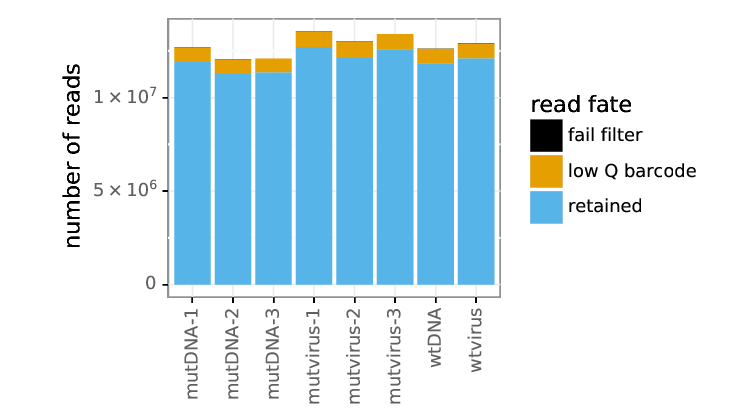

In [6]:
showPDF(countsplotprefix + '_readstats.pdf', width=500)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample.
Barcodes need to be observed multiple times to be useful for [barcoded-subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) error correction.
Many barcodes are observed multiple times. 
There is also a large bar at 1, which probably corresponds to a mix of barcodes that were only observed once and sequencing errors on other barcodes that spuriously gave rise to an apparently unique sequence.
Overall, the distributions here indicate that most multiply sequenced barcodes were sequenced > 2 times, which suggests that most of the peak at one is probably due to sequencing errors on barcodes, and suggests that sequencing to greater depth probably would not help all that much for these samples.

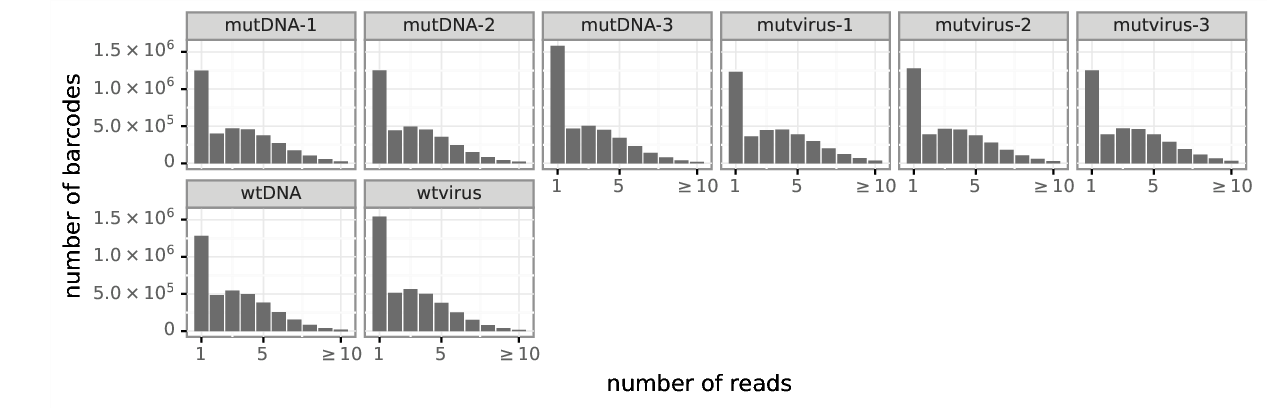

In [7]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes.
Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the HA gene properly. 
The fact that most barcodes with multiple reads aligned is good -- if that was not the case then it would indicate that something went wrong, such as perhaps having the wrong `--alignspecs` when calling `dms2_batch_bcsubamp`.

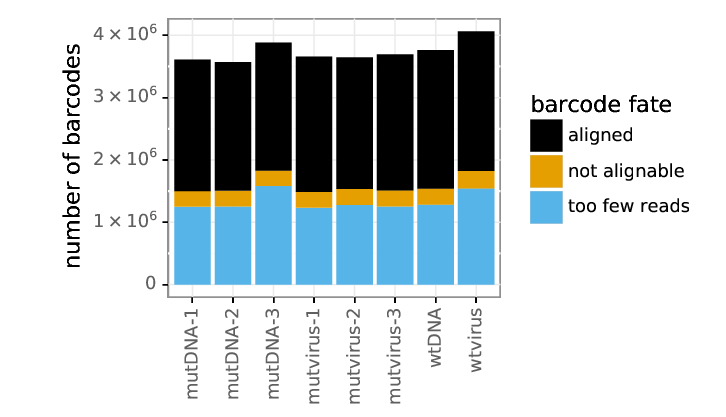

In [8]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene.
There is a bit of variation across the gene due to unequal numbers of barcodes for different subamplicons, but the variation is fairly modest.
The typical site has about $3 \times 10^5$ called codons, which makes sense as most samples had about $2 \times 10^6$ total aligned barcodes and the gene was split into 6 subamplicons.
If the coverage was wildly uneven across the gene, that would suggest that the subamplicons were pooled very unevenly.

Note that there are often little dips near the middle of the subamplicons. 
These correspond to regions covered by the ends of the R1 and R2 reads, and so are usually of lower sequencing quality.
In addition, sometime if one read is much lower quality it can interfere with good sequencing from the other read in regions of overlap. 
Sometimes these issues can be improved by adjusting `--R1trim` and `--R2trim` to [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp).

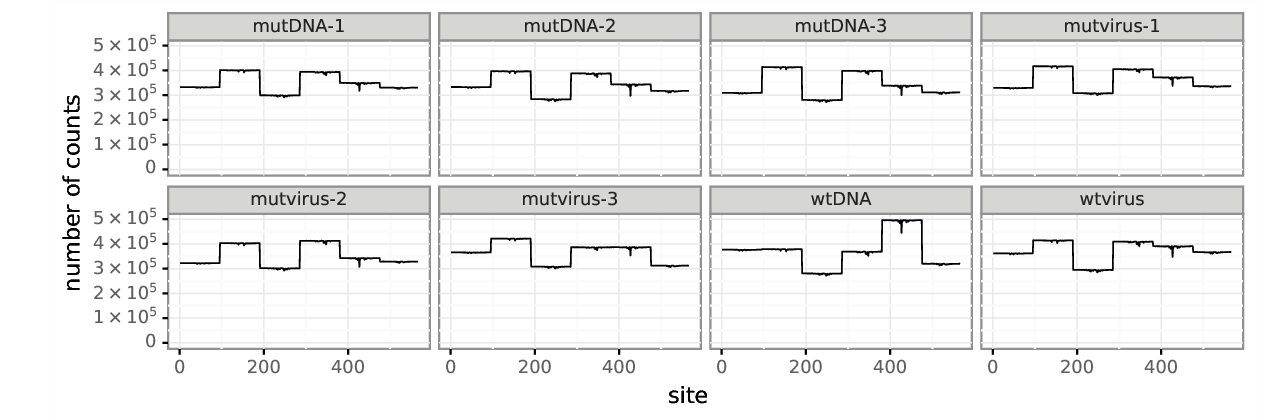

In [9]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site.
Generally, things are about as expected -- there is a fairly high mutation frequency across all sites in the mutant DNA library samples, mutations remain prevalent at many but not all sites in the mutant viruses (presumably there is more selection against mutations at some sites than others), and the mutation frequency (presumably mostly sequencing errors) is much lower in the wildtype plasmid and wildtype virus.

Note that there are few peaks in mutation frequency (probably sequencing errors) in the wildtype control samples.
These peaks often appear to correspond to the center of the subamplicons where there are slight dips in coverage in the depth plot shown above.
Again, this is usually due to read quality dropping off near the end of R1 and R2, and the effect can often be somewhat ameliorated by adjusting the `--R1trim` and `--R2trim` parameters to [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) to avoid low quality ends of the reads.

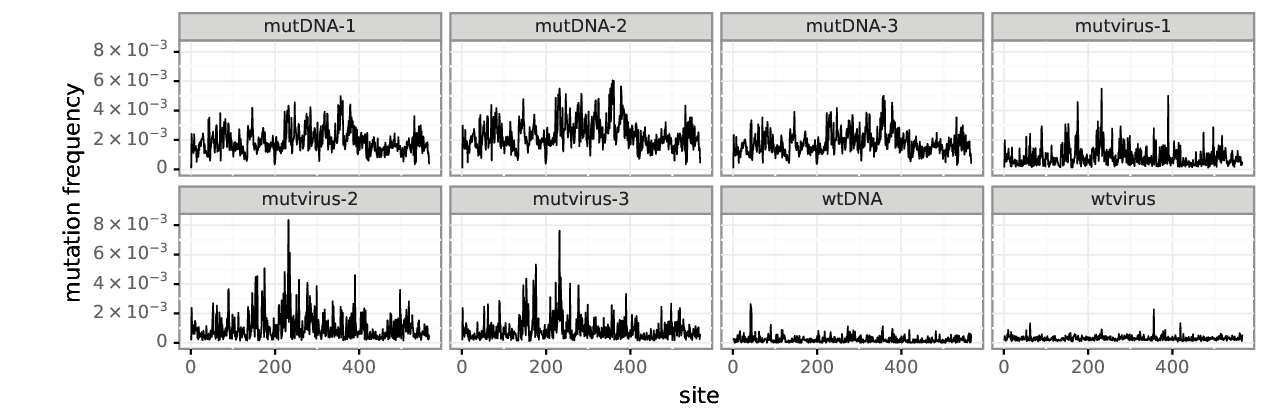

In [10]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene.
As expected, we see strong selection against stop codons and moderate selection against nonsynonymous mutations in the *mutvirus* samples relative to the *mutDNA* samples, indicating purifying selection against deleterioius changes.
The wildtype controls have lower mutation rates, reflecting the underlying rate of errors in the whole experimental process.

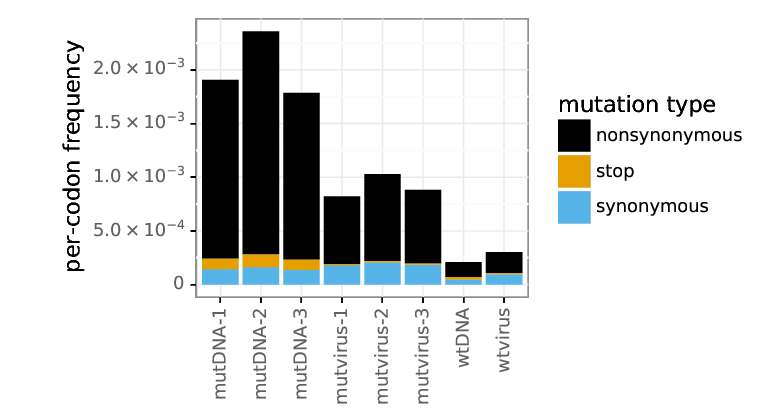

In [11]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

The numerical data in the `*_codonmuttypes.pdf` plot shown above may also be of interest if you want to know the precise mutation frequencies.
That data is written to a file called `*_codonmutttypes.csv`, the contents of which are displayed below.

In [12]:
codonmuttypes = pandas.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA-1,0.001664,0.000099,0.000144
mutDNA-2,0.002077,0.000119,0.000163
mutDNA-3,0.001553,0.000096,0.000138
mutvirus-1,0.000630,0.000013,0.000181
mutvirus-2,0.000809,0.000014,0.000207
mutvirus-3,0.000683,0.000015,0.000185
wtDNA,0.000138,0.000023,0.000048
wtvirus,0.000194,0.000012,0.000096


The `*_codonntchanges.pdf` plot below shows per-codon frequency across the entire gene of codon mutations that change different numbers of nucleotides (e.g., `ATG` to `AAG` changes 1 nucleotide, `ATG` to `AAC` changes 2 nucleotides, and `ATG` to `CAC` changes 3 nucleotides).
Since we are dealing with codon-mutant libraries in this experiments, we see all three types of mutations in the mutagenized *mutDNA* and *mutvirus* samples.
The "mutations" in the wildtype controls are sequencing errors, and those are almost all single-nucleotide changes since it is very rare for two nucleotides in the same codon to both experience a sequencing error.

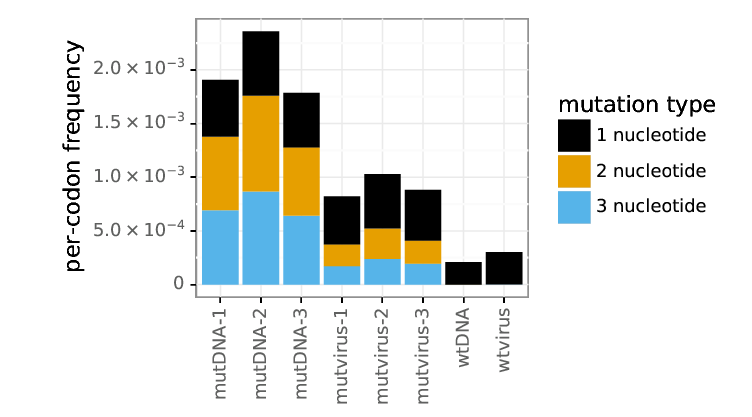

In [13]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with **one** nucleotide change.
This plot is mostly useful to check if there is a large bias in which mutations appear. 
In particular, if you are getting [oxidative damage (which causes `G` to `T` mutations)](https://dx.doi.org/10.1038/349431a0) during the library preparation process, you will see a large excess of `C` to `A` or `G` to `T` mutations (or both).
For instance, in the case of influenza, when we get bad oxidative damage, then we see an excess of `C` to `A` mutations in the final cDNA since the damage is occurring to a ssRNA genome.
If you are sequencing something without polarity, you might see both types of mutations.

There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (`G` <-> `A` and `C` <-> `T`) are a bit more common than most of the other types of mutations (all of which are transversions).
This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/).

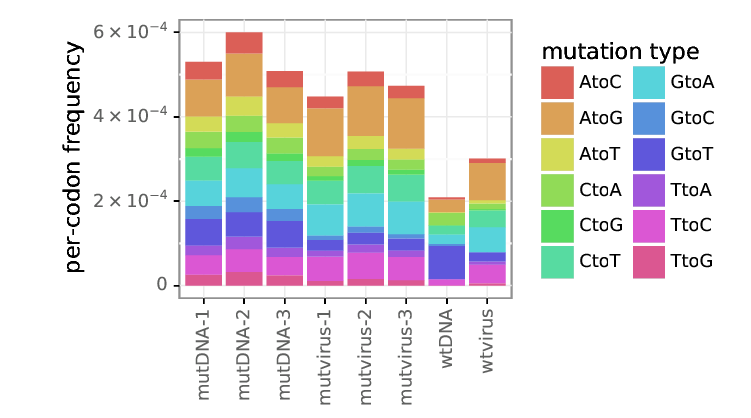

In [14]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=500)